# **SHREC'22 track: Pothole and crack detection on road pavement using RGB-D images**

# Preparation

## Install requirements

In [4]:
%cd shrec22-pothole
!pip install -e .

[Errno 2] No such file or directory: 'main'
/content/main
Obtaining file:///content/main
     |████████████████████████████████| 431 kB 14.5 MB/s 
     |████████████████████████████████| 596 kB 93.7 MB/s 
     |████████████████████████████████| 74 kB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 9.6 MB/s 
     |████████████████████████████████| 21.8 MB 219 kB/s 
     |████████████████████████████████| 3.5 MB 56.8 MB/s 
     |████████████████████████████████| 631 kB 73.3 MB/s 
     |████████████████████████████████| 112 kB 71.6 MB/s 
     |████████████████████████████████| 58 kB 8.4 MB/s 
     |████████████████████████████████| 376 kB 69.6 MB/s 
     |████████████████████████████████| 895 kB 82.7 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
     |████████████████████████████████| 6.5 MB 60.3 MB/s 
  Created wheel for gdown: filename=gdo

## Prepare sample dataset

In [5]:
!mkdir /content/shrec22-pothole/data

# Download sample data
!wget http://shrec.ge.imati.cnr.it/shrec22_road_pothole_and_crack_reco/sh22_potholes_cracks_samples.zip -O /content/shrec22-pothole/data/samples.zip
!unzip /content/shrec22-pothole/data/samples.zip -d /content/shrec22-pothole/data
!tar -xf /content/shrec22-pothole/data/sh22_potholes_cracks_samples/pothole-mix-tiny_image_sample.tar.xz -C /content/shrec22-pothole/data/sh22_potholes_cracks_samples
!tar -xf /content/shrec22-pothole/data/sh22_potholes_cracks_samples/pothole-mix-tiny_video_sample.tar.xz -C /content/shrec22-pothole/data/sh22_potholes_cracks_samples

# Clean up zip files
!rm -rf /content/shrec22-pothole/data/samples.zip
!rm -rf /content/shrec22-pothole/data/sh22_potholes_cracks_samples/pothole-mix-tiny_image_sample.tar.xz
!rm -rf /content/shrec22-pothole/data/sh22_potholes_cracks_samples/pothole-mix-tiny_video_sample.tar.xz

--2022-03-03 13:45:15--  http://shrec.ge.imati.cnr.it/shrec22_road_pothole_and_crack_reco/sh22_potholes_cracks_samples.zip
Resolving shrec.ge.imati.cnr.it (shrec.ge.imati.cnr.it)... 150.145.8.148
Connecting to shrec.ge.imati.cnr.it (shrec.ge.imati.cnr.it)|150.145.8.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37262740 (36M) [application/zip]
Saving to: ‘/content/main/data/samples.zip’

/content/main/data/ 100%[===================>]  35.54M  10.2MB/s    in 3.7s    

2022-03-03 13:45:19 (9.70 MB/s) - ‘/content/main/data/samples.zip’ saved [37262740/37262740]

Archive:  /content/main/data/samples.zip
   creating: /content/main/data/sh22_potholes_cracks_samples/
 extracting: /content/main/data/sh22_potholes_cracks_samples/pothole-mix-tiny_image_sample.tar.xz  
 extracting: /content/main/data/sh22_potholes_cracks_samples/pothole-mix-tiny_video_sample.tar.xz  
  inflating: /content/main/data/sh22_potholes_cracks_samples/video_sample_readme.txt  


In [6]:
# Make classnames text file
%%writefile /content/shrec22-pothole/configs/segmentation/classes.txt
background
crack
pothole

Overwriting /content/main/configs/segmentation/classes.txt


## Download checkpoints and configs

In [2]:
# Download model checkpoints and configs
from theseus.utilities.download import download_from_drive
download_from_drive('1mWj4i9pMuC6_1UjrKg_QXBPhLEkuQz4U', output='/content/shrec22-pothole/ckpt.zip',cache=False)
!unzip /content/shrec22-pothole/ckpt.zip -d /content/shrec22-pothole/

# Clean up
!rm -rf /content/shrec22-pothole/ckpt.zip

Downloading...
From: https://drive.google.com/uc?id=1ahJ_1rEcRng8FyfjXG0pizVAfI2QP_sn
To: /content/main/ckpt.zip
100%|██████████| 137M/137M [00:02<00:00, 58.5MB/s]


Archive:  /content/main/ckpt.zip
   creating: /content/main/ckpt/
   creating: /content/main/ckpt/0.segformer/
  inflating: /content/main/ckpt/0.segformer/best.pth  
  inflating: /content/main/ckpt/0.segformer/pipeline.yaml  
  inflating: /content/main/ckpt/0.segformer/test.yaml  
  inflating: /content/main/ckpt/0.segformer/test_video.yaml  
  inflating: /content/main/ckpt/0.segformer/transform.yaml  
   creating: /content/main/ckpt/1.deeplabv3plus/
  inflating: /content/main/ckpt/1.deeplabv3plus/best.pth  
  inflating: /content/main/ckpt/1.deeplabv3plus/pipeline.yaml  
  inflating: /content/main/ckpt/1.deeplabv3plus/test.yaml  
  inflating: /content/main/ckpt/1.deeplabv3plus/test_video.yaml  
  inflating: /content/main/ckpt/1.deeplabv3plus/transform.yaml  
   creating: /content/main/ckpt/2.maskedsoftcps-dlunet/
  inflating: /content/main/ckpt/2.maskedsoftcps-dlunet/best.pth  
  inflating: /content/main/ckpt/2.maskedsoftcps-dlunet/pipeline.yaml  
  inflating: /content/main/ckpt/2.maske

# **Run 0: SegFormer**

In [3]:
IMAGE_DIR = '/content/shrec22-pothole/data/sh22_potholes_cracks_samples/pothole-mix-tiny/training/cracks-and-potholes-in-road/images'
VIDEO_PATH = '/content/shrec22-pothole/data/sh22_potholes_cracks_samples/depthai-video-20220130-094009-color-033-063.h265.mp4'

## Inference on images folder

In [6]:
%cd shrec22-pothole
!PYTHONPATH=. python /content/shrec22-pothole/configs/segmentation/infer.py \
              -c /content/shrec22-pothole/ckpt/0.segformer/test.yaml \
              -o data.dataset.args.image_dir=$IMAGE_DIR

[Errno 2] No such file or directory: 'main'
/content/main
[03-03-22 13:48:52][stdout_logger.py::106][INFO]: {
    "global": {
        "debug": true,
        "cfg_transform": "ckpt/0.segformer/transform.yaml",
        "save_dir": "outputs/0.segformer/images",
        "device": "cuda:0",
        "weights": "ckpt/0.segformer/best.pth"
    },
    "model": {
        "name": "SegFormer",
        "args": {
            "pretrained": "nvidia/segformer-b0-finetuned-ade-512-512",
            "image_size": 512
        }
    },
    "data": {
        "dataset": {
            "name": "ImageDataset",
            "args": {
                "image_dir": "/content/main/data/sh22_potholes_cracks_samples/pothole-mix-tiny/training/cracks-and-potholes-in-road/images",
                "txt_classnames": "configs/segmentation/classes.txt"
            }
        },
        "dataloader": {
            "name": "DataLoaderWithCollator",
            "args": {
                "batch_size": 8,
                "drop_last

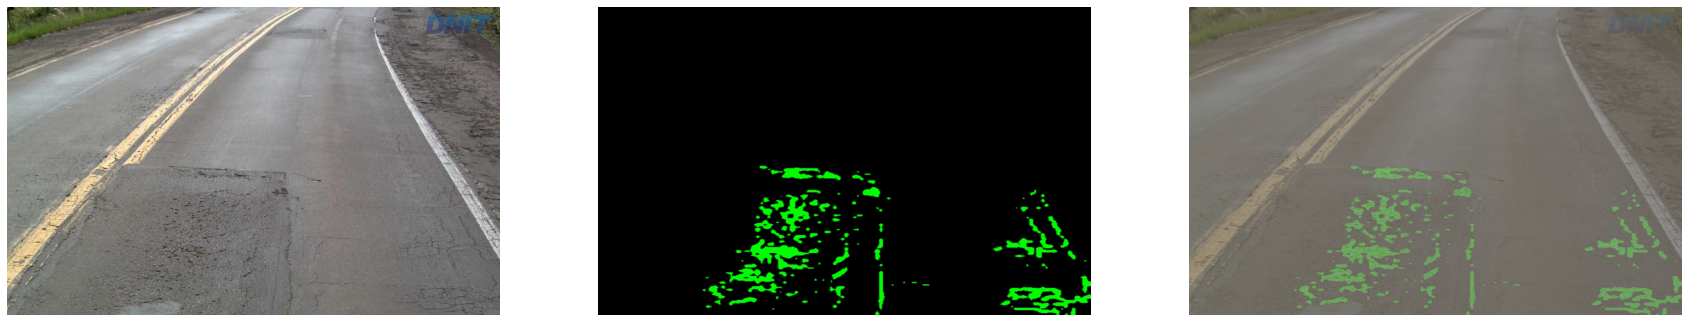

In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt

raw = Image.open(os.path.join(IMAGE_DIR, "1014636_RS_386_386RS124739_30105.jpg"))
mask = Image.open("/content/shrec22-pothole/outputs/0.segformer/images/masks/1014636_RS_386_386RS124739_30105.jpg")
overlay = Image.open("/content/shrec22-pothole/outputs/0.segformer/images/overlays/1014636_RS_386_386RS124739_30105.jpg")

fig, axs = plt.subplots(1, 3, figsize=(30,10))
axs[0].imshow(raw)
axs[1].imshow(mask)
axs[2].imshow(overlay)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

plt.show()

## Inference on video

In [8]:
%cd shrec22-pothole
!PYTHONPATH=. python /content/shrec22-pothole/configs/segmentation/infer_video.py \
              -c /content/shrec22-pothole/ckpt/0.segformer/test_video.yaml \
              -o data.dataset.args.video_path=$VIDEO_PATH

[Errno 2] No such file or directory: 'main'
/content/main
[03-03-22 13:49:42][stdout_logger.py::106][INFO]: {
    "global": {
        "debug": true,
        "cfg_transform": "ckpt/0.segformer/transform.yaml",
        "save_dir": "outputs/0.segformer/images",
        "device": "cuda:0",
        "weights": "ckpt/0.segformer/best.pth"
    },
    "model": {
        "name": "SegFormer",
        "args": {
            "pretrained": "nvidia/segformer-b0-finetuned-ade-512-512",
            "image_size": 512
        }
    },
    "data": {
        "dataset": {
            "name": "VideoDataset",
            "args": {
                "video_path": "/content/main/data/sh22_potholes_cracks_samples/depthai-video-20220130-094009-color-033-063.h265.mp4",
                "txt_classnames": "configs/segmentation/classes.txt"
            }
        },
        "dataloader": {
            "name": "DataLoaderWithCollator",
            "args": {
                "batch_size": 8,
                "drop_last": fals

# **Run 1: Efficient DeeplabV3+**

In [1]:
IMAGE_DIR = '/content/shrec22-pothole/data/sh22_potholes_cracks_samples/pothole-mix-tiny/training/cracks-and-potholes-in-road/images'
VIDEO_PATH = '/content/shrec22-pothole/data/sh22_potholes_cracks_samples/depthai-video-20220130-094009-color-033-063.h265.mp4'

## Inference on images folder

In [2]:
%cd shrec22-pothole
!PYTHONPATH=. python /content/shrec22-pothole/configs/segmentation/infer.py \
              -c /content/shrec22-pothole/ckpt/1.deeplabv3plus/test.yaml \
              -o data.dataset.args.image_dir=$IMAGE_DIR

/content/main
[03-03-22 13:09:25][stdout_logger.py::106][INFO]: {
    "global": {
        "debug": true,
        "cfg_transform": "ckpt/1.deeplabv3plus/transform.yaml",
        "save_dir": "outputs/1.deeplabv3plus/images",
        "device": "cuda:0",
        "weights": "ckpt/1.deeplabv3plus/best.pth"
    },
    "model": {
        "name": "BaseSegModel",
        "args": {
            "backbone_name": "deeplabv3plus",
            "encoder_name": "efficientnet-b0"
        }
    },
    "data": {
        "dataset": {
            "name": "ImageDataset",
            "args": {
                "image_dir": "/content/main/data/sh22_potholes_cracks_samples/pothole-mix-tiny/training/cracks-and-potholes-in-road/images",
                "txt_classnames": "configs/segmentation/classes.txt"
            }
        },
        "dataloader": {
            "name": "DataLoaderWithCollator",
            "args": {
                "batch_size": 8,
                "drop_last": false,
                "shuffle": t

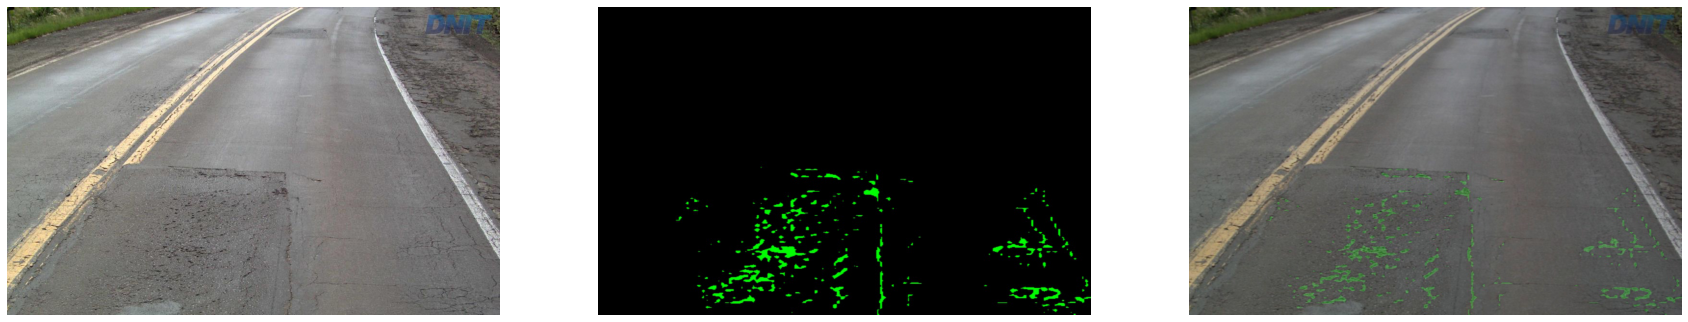

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

raw = Image.open(os.path.join(IMAGE_DIR, "1014636_RS_386_386RS124739_30105.jpg"))
mask = Image.open("/content/shrec22-pothole/outputs/1.deeplabv3plus/images/masks/1014636_RS_386_386RS124739_30105.jpg")
overlay = Image.open("/content/shrec22-pothole/outputs/1.deeplabv3plus/images/overlays/1014636_RS_386_386RS124739_30105.jpg")

fig, axs = plt.subplots(1, 3, figsize=(30,10))
axs[0].imshow(raw)
axs[1].imshow(mask)
axs[2].imshow(overlay)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

plt.show()

## Inference on video

In [5]:
%cd shrec22-pothole
!PYTHONPATH=. python /content/shrec22-pothole/configs/segmentation/infer_video.py \
              -c /content/shrec22-pothole/ckpt/1.deeplabv3plus/test_video.yaml \
              -o data.dataset.args.video_path=$VIDEO_PATH

[Errno 2] No such file or directory: 'main'
/content/main
[03-03-22 13:12:46][stdout_logger.py::106][INFO]: {
    "global": {
        "debug": true,
        "cfg_transform": "ckpt/1.deeplabv3plus/transform.yaml",
        "save_dir": "outputs/1.deeplabv3plus/videos",
        "device": "cuda:0",
        "weights": "ckpt/1.deeplabv3plus/best.pth"
    },
    "model": {
        "name": "BaseSegModel",
        "args": {
            "backbone_name": "deeplabv3plus",
            "encoder_name": "efficientnet-b0"
        }
    },
    "data": {
        "dataset": {
            "name": "VideoDataset",
            "args": {
                "video_path": "/content/main/data/sh22_potholes_cracks_samples/depthai-video-20220130-094009-color-033-063.h265.mp4",
                "txt_classnames": "configs/segmentation/classes.txt"
            }
        },
        "dataloader": {
            "name": "DataLoaderWithCollator",
            "args": {
                "batch_size": 8,
                "drop_last"

# **Run 2: Masked Soft CPS with DeeplabV3+ and Unet++**

In [9]:
IMAGE_DIR = '/content/shrec22-pothole/data/sh22_potholes_cracks_samples/pothole-mix-tiny/training/cracks-and-potholes-in-road/images'
VIDEO_PATH = '/content/shrec22-pothole/data/sh22_potholes_cracks_samples/depthai-video-20220130-094009-color-033-063.h265.mp4'

## Inference on images folder

In [10]:
%cd shrec22-pothole
!PYTHONPATH=. python /content/shrec22-pothole/configs/cps/infer.py \
              -c /content/shrec22-pothole/ckpt/2.maskedsoftcps-dlunet/test.yaml \
              -o data.dataset.args.image_dir=$IMAGE_DIR

[Errno 2] No such file or directory: 'main'
/content/main
[03-03-22 13:15:57][stdout_logger.py::106][INFO]: {
    "global": {
        "debug": true,
        "cfg_transform": "ckpt/2.maskedsoftcps-dlunet/transform.yaml",
        "save_dir": "outputs/2.maskedsoftcps-dlunet/images",
        "device": "cuda:0",
        "weights": "ckpt/2.maskedsoftcps-dlunet/best.pth"
    },
    "model1": {
        "name": "BaseSegModel",
        "args": {
            "backbone_name": "unetplusplus",
            "encoder_name": "efficientnet-b0"
        }
    },
    "model2": {
        "name": "BaseSegModel",
        "args": {
            "backbone_name": "deeplabv3plus",
            "encoder_name": "efficientnet-b0"
        }
    },
    "data": {
        "dataset": {
            "name": "ImageDataset",
            "args": {
                "image_dir": "/content/main/data/sh22_potholes_cracks_samples/pothole-mix-tiny/training/cracks-and-potholes-in-road/images",
                "txt_classnames": "configs/

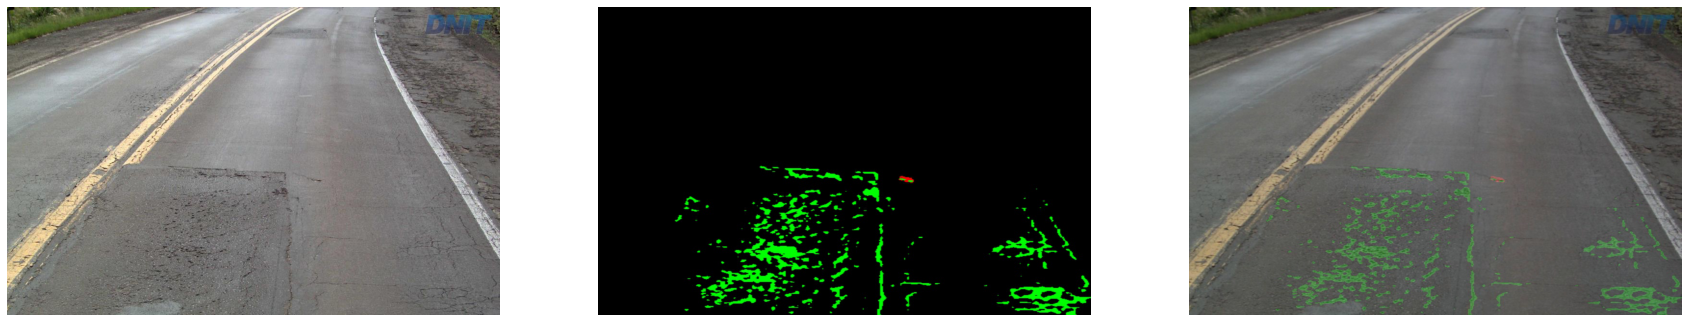

In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt

raw = Image.open(os.path.join(IMAGE_DIR, "1014636_RS_386_386RS124739_30105.jpg"))
mask = Image.open("/content/shrec22-pothole/outputs/2.maskedsoftcps-dlunet/images/masks/1014636_RS_386_386RS124739_30105.jpg")
overlay = Image.open("/content/shrec22-pothole/outputs/2.maskedsoftcps-dlunet/images/overlays/1014636_RS_386_386RS124739_30105.jpg")

fig, axs = plt.subplots(1, 3, figsize=(30,10))
axs[0].imshow(raw)
axs[1].imshow(mask)
axs[2].imshow(overlay)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

plt.show()

## Inference on video

In [13]:
%cd shrec22-pothole
!PYTHONPATH=. python /content/shrec22-pothole/configs/cps/infer_video.py \
              -c /content/shrec22-pothole/ckpt/2.maskedsoftcps-dlunet/test_video.yaml \
              -o data.dataset.args.video_path=$VIDEO_PATH

[Errno 2] No such file or directory: 'main'
/content/main
[03-03-22 13:17:05][stdout_logger.py::106][INFO]: {
    "global": {
        "debug": true,
        "cfg_transform": "ckpt/2.maskedsoftcps-dlunet/transform.yaml",
        "save_dir": "outputs/2.maskedsoftcps-dlunet/videos",
        "device": "cuda:0",
        "weights": "ckpt/2.maskedsoftcps-dlunet/best.pth"
    },
    "model1": {
        "name": "BaseSegModel",
        "args": {
            "backbone_name": "unetplusplus",
            "encoder_name": "efficientnet-b0"
        }
    },
    "model2": {
        "name": "BaseSegModel",
        "args": {
            "backbone_name": "deeplabv3plus",
            "encoder_name": "efficientnet-b0"
        }
    },
    "data": {
        "dataset": {
            "name": "VideoDataset",
            "args": {
                "video_path": "/content/main/data/sh22_potholes_cracks_samples/depthai-video-20220130-094009-color-033-063.h265.mp4",
                "txt_classnames": "configs/segment